# Combining combinatorial scenario analysis with uncertainty

The default way to do combinatorial scenario analysis will only select each scenario combination once. In other words, if in one system we had scenarios `A` and `B`, and in another system we had scenarios `🚲` and `🎺`, then we would have four possible scenario combinations:

* `('A', '🚲')`
* `('B', '🚲')`
* `('A', '🎺')`
* `('B', '🎺')`

However, this doesn't really work for cases where we have quantitative uncertainty in each scenario. We would like to be able to draw multiple samples from `('A', '🚲')` before switching to the next combination.

## Example system

Let's set up an example system and demo this functionality.

In [1]:
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import bw_processing as bwp
import itertools
import matrix_utils as mu
import numpy as np
import pandas as pd
import seaborn as sb
import stats_arrays as sa

Download an example database to work with. This comes with its own LCIA methods, which is convenient.

In [2]:
bi.install_project("USEEIO-1.1", overwrite_existing=True)
bd.projects.set_current("USEEIO-1.1")
bd.databases

Restoring project backup archive - this could take a few minutes...
Restored project: USEEIO-1.1


Databases dictionary with 1 object(s):
	USEEIO-1.1

This IO data doesn't have any uncertainty - but we can [cheat and add some](https://github.com/brightway-lca/brightway2-data/blob/8609efb4d8dd165687812dba4386601637fbe831/bw2data/utils.py#L128).

In [3]:
useeio = bd.Database('USEEIO-1.1')
useeio.write(bd.utils.uncertainify(
    data=useeio.load(), 
    distribution=sa.NormalUncertainty,
))

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2649/2649 [00:34<00:00, 76.89it/s] 


Vacuuming database 


We need some scenarios. We can define these manually. This is an example, so the actual system is a bit silly.

In [4]:
bored_teenagers = bd.Database("Entertainment")
bored_teenagers.register()
entertainment = bored_teenagers.new_node(
    name='Entertainment',
    code='e',
    location='US',
    unit='hour',
)
entertainment.save()
written_entertainment = bored_teenagers.new_node(
    name='Written entertainment',
    code='w',
    location='US',
    unit='hour'
)
written_entertainment.save()
av_entertainment = bored_teenagers.new_node(
    name='Audio-visual entertainment',
    code='a',
    location='US',
    unit='hour'
)
av_entertainment.save()
entertainment.new_edge(
    amount=0.1,
    type='technosphere',
    input=written_entertainment
).save()
entertainment.new_edge(
    amount=0.9,
    type='technosphere',
    input=av_entertainment
).save()

In [5]:
television = bd.get_node(name='Radio and television', type='product')
movies = bd.get_node(name='Movies and film', type='product')
books = bd.get_node(name='Books; at publisher', type='product')
magazines = bd.get_node(name='Magazines and journals; at publisher', type='product')

## Create combinatorial scenario datapackage

We can have two places where there are different scenarios - one which varies the price of the different entertainment options, and another which varies the balance between written and AV entertainment. To do this we will create a new combinatorial scenario datapackage. See the [`bw_processing` documentation for more on datapackages](https://github.com/brightway-lca/bw_processing).

In [6]:
dp = bwp.create_datapackage(
    name="entertainment-options",
    combinatorial=True
)

The first scenario - changing the prices of different entertainment options.

In [7]:
dp.add_persistent_array(
    matrix='technosphere_matrix',
    name='price options',
    indices_array=np.array([
        (television.id, av_entertainment.id),
        (movies.id, av_entertainment.id),
        (books.id, written_entertainment.id),
        (magazines.id, written_entertainment.id),
    ], dtype=bwp.INDICES_DTYPE),
    # Scenarios are base case, cheaper, more expensive
    data_array=np.array([
        [0.25, 0.1, 0.5],  # Price per hour of television
        [10, 5, 20],  # Price per hour of movies
        [5, 2, 10],  # Price per hour of books
        [2.5, 1, 10],  # Price per hour of magazines
    ]),
    flip_array=np.array([True] * 4),  # Four technosphere input edge values to vary
)
first_scenario_labels = ['normal pricing', 'cheap pricing', 'expensive pricing']

The next scenario is screen junkie versus bookworm.

In [8]:
dp.add_persistent_array(
    matrix='technosphere_matrix',
    name='books versus film',
    indices_array=np.array([
        (av_entertainment.id, entertainment.id),
        (written_entertainment.id, entertainment.id),
    ], dtype=bwp.INDICES_DTYPE),
    # Scenarios are base case, cheaper, more expensive
    data_array=np.array([
        [0.9, 0.5],  # Fraction of entertainment hours spent on film
        [0.1, 0.5],  # Fraction of entertainment hours spent on books
    ]),
    flip_array=np.array([True] * 2),  # Two technosphere input edge values to vary
)
second_scenario_labels = ['screen junkie', 'bookworm']

In [9]:
scenario_lookup = {
    (a, c): (b, d) 
    for (a, b), (c, d) in itertools.product(
        enumerate(first_scenario_labels), 
        enumerate(second_scenario_labels)
    )
}
scenario_lookup

{(0, 0): ('normal pricing', 'screen junkie'),
 (0, 1): ('normal pricing', 'bookworm'),
 (1, 0): ('cheap pricing', 'screen junkie'),
 (1, 1): ('cheap pricing', 'bookworm'),
 (2, 0): ('expensive pricing', 'screen junkie'),
 (2, 1): ('expensive pricing', 'bookworm')}

## Standard calculations

Let's look at the default behaviour. We need to create the LCA object; we can then iterate over it to calculate results for each scenario combination. But we first need to pick an impact category.

In [10]:
lcia_category = bd.Method(('Resource Use', 'NREN'))

In [11]:
lca = bc.LCA(
    demand={entertainment.id: 1},
    data_objs=[
        useeio.datapackage(), 
        bored_teenagers.datapackage(), 
        dp, 
        lcia_category.datapackage()
    ],
    use_distributions=True,
    use_arrays=True,
)
lca.lci()
lca.lcia()

To get access to the combinatorial indexer is a little bit awkward. You can [read about mapped matrices](https://github.com/brightway-lca/matrix_utils), or just use the following :)

In [12]:
def get_combinatorial_indexer(lca: bc.LCA) -> mu.indexers.CombinatorialIndexer:
    """Get the first available combinatorial indexer in the technosphere mapped matrix"""
    for resource_group in lca.technosphere_mm.groups:
        indexer = resource_group.indexer
        if isinstance(indexer, mu.indexers.Proxy):
            return indexer.indexer
    raise ValueError("Still haven't found what i'm looking for")

In [13]:
indexer = get_combinatorial_indexer(lca)
print("Current value is", indexer.index)

Current value is (0, 0)


We can now iterate over the LCA object:

In [14]:
# If we start iterating we go already to possibility number two
# This keeps us at the first one for the first iteration
lca.keep_first_iteration()

pd.DataFrame([
    {
        'first': scenario_lookup[indexer.index][0],
        'second': scenario_lookup[indexer.index][1],
        'score': lca.score
    }
    for _ in lca
])

,first,second,score
0,normal pricing,screen junkie,6.575572e-08
1,normal pricing,bookworm,5.938128e-08
2,cheap pricing,screen junkie,3.019357e-08
3,cheap pricing,bookworm,2.846311e-08
4,expensive pricing,screen junkie,1.205897e-07
5,expensive pricing,bookworm,1.534673e-07


## Multiple samples per combo

The code defining the iterators is pretty simple. We have one master combinatorial iterator, and instance of [`matrix_utils.indexers.CombinatorialIndexer`](https://github.com/brightway-lca/matrix_utils/blob/007e6ed3a2103dc27592952a6897e4de6d2efaf2/matrix_utils/indexers.py#L49). For each datapackage resource, this is referenced by a [`matrix_utils.indexers.Proxy`](https://github.com/brightway-lca/matrix_utils/blob/007e6ed3a2103dc27592952a6897e4de6d2efaf2/matrix_utils/indexers.py#L63C7-L63C12) which refers to *one part* of the master indexer value. So if the master indexer state was `(2, 4)`, the first proxy would return `2`, while the second proxy would return `4`.

The [`MappedMatrix` class](https://github.com/brightway-lca/matrix_utils/blob/007e6ed3a2103dc27592952a6897e4de6d2efaf2/matrix_utils/mapped_matrix.py#L14) does a lot, and we don't want to mess with it too much. So the first thing we need to do is to create a new kind of combinatorial indexer which stays at the same value for a fixed number of iterations.

In [15]:
class RepetitiveCombinatorialIndexer(mu.indexers.CombinatorialIndexer):
    def __init__(self, current_indexer: mu.indexers.CombinatorialIndexer, num_repetitions: int):
        self.max_values = current_indexer.max_values
        # Will be advanced one by `next` call
        self.count = -1
        self.num_repetitions = num_repetitions
        self.reset()

    def __next__(self):
        if not hasattr(self, "index"):
            # First iteration
            self.index = next(self.slow_iterator)
        elif self.count == self.num_repetitions - 1:
            self.count = 0
            self.index = next(self.slow_iterator)
        else:
            # self.index stays the same
            self.count += 1
        return self.index

    def reset(self):
        self.count = -1
        self.slow_iterator = itertools.product(*[range(x) for x in self.max_values])
        next(self)

It's easy to make mistakes with this kind of thing, so let's check it:

In [16]:
indexer.reset()

rci = RepetitiveCombinatorialIndexer(indexer, 3)

while True:
    try:
        print(next(rci))
    except StopIteration:
        break

(0, 0)
(0, 0)
(0, 0)
(0, 1)
(0, 1)
(0, 1)
(1, 0)
(1, 0)
(1, 0)
(1, 1)
(1, 1)
(1, 1)
(2, 0)
(2, 0)
(2, 0)
(2, 1)
(2, 1)
(2, 1)


That looks pretty good! That's what we want, and we don't have off by one errors (there were some on the first try).

We can reuse the existing LCA, but we need to substitute this new master indexer in. We can also add new `Proxy` objects which reference our `RepetitiveCombinatorialIndexer` at the same time.

In [17]:
new_indexer = RepetitiveCombinatorialIndexer(indexer, 100)

for package, resources in lca.technosphere_mm.packages.items():
    if package.indexer is indexer:
        package.indexer = new_indexer
        # Stolen from 
        #https://github.com/brightway-lca/matrix_utils/blob/main/matrix_utils/mapped_matrix.py#L211C1-L212C85
        for i, obj in enumerate(resources):
            obj.add_combinatorial_indexer(indexer=package.indexer, offset=i)

We can now calculate results, and display them nicely:

In [18]:
df = pd.DataFrame([
    {
        'first': scenario_lookup[new_indexer.index][0],
        'second': scenario_lookup[new_indexer.index][1],
        'score': lca.score
    }
    for _ in lca
])

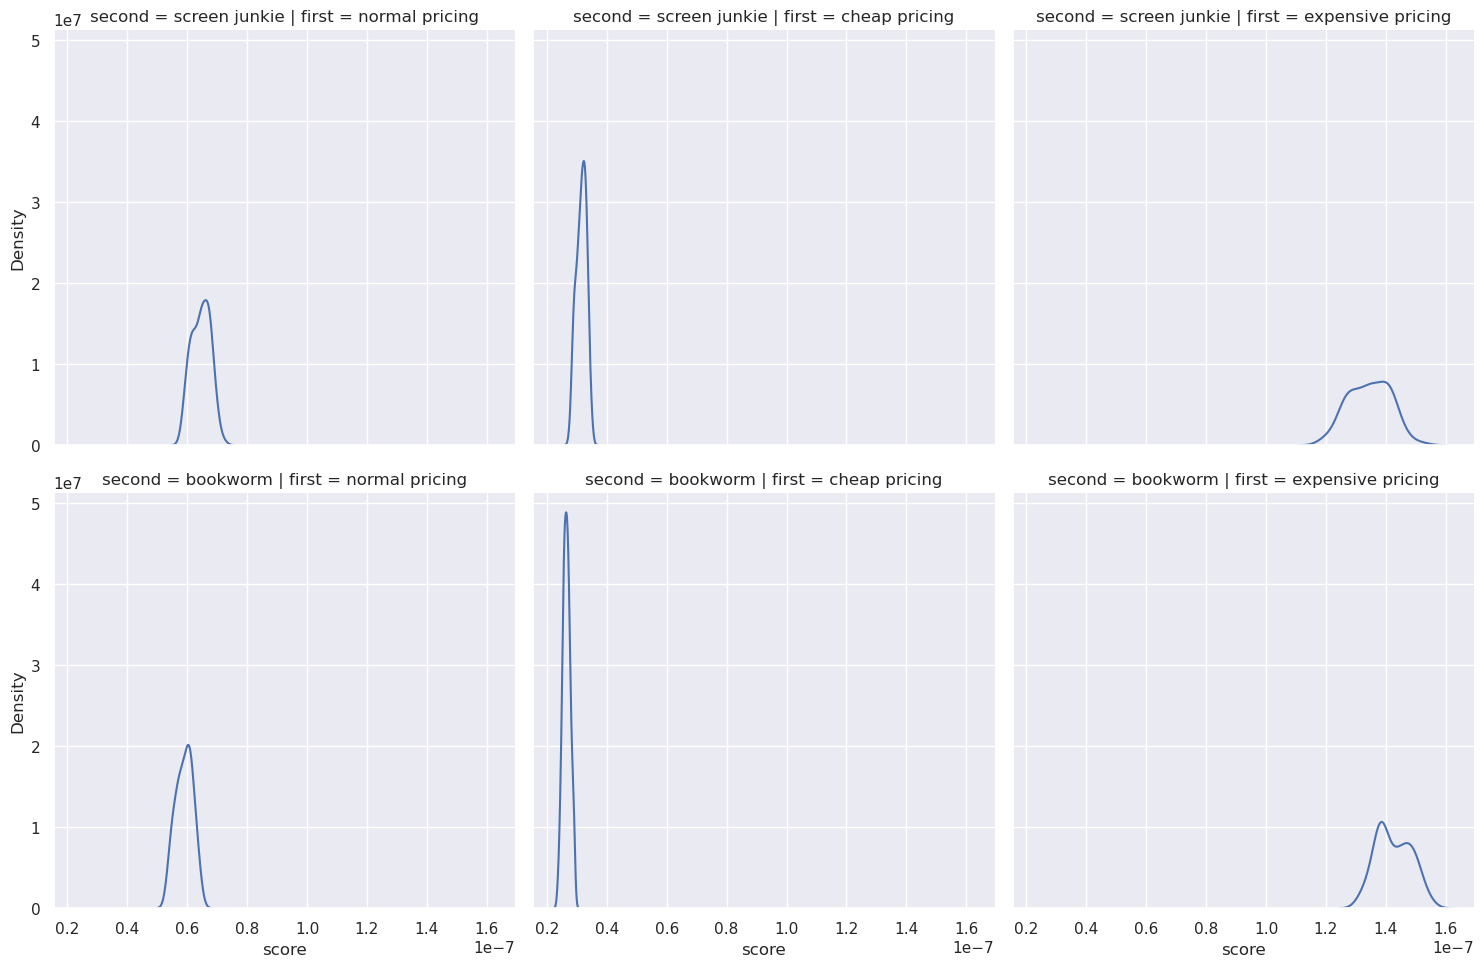

In [19]:
sb.set_theme(style="darkgrid")
sb.displot(
    df, x="score", col="first", row="second", kind='kde',
)